# SI670 Kaggle Challenge 1
* Team: always 22
* Members: Lan Xu (), Yufeng Song (yfsong)

In [59]:
import os, random, warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [25]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Things to think about:
1. How much train data to sample? how to make sure samples are representative?
2. class imbalance? how to deal with

In [4]:
%ls

README.md                     machine_text_detection.ipynb
data/


In [5]:
train = pd.read_csv("data/si670_kaggle1_train.csv")
validation = pd.read_csv("data/si670_kaggle1_validation.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
train.info()
print()
validation.info()
print()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319071 entries, 0 to 319070
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    319071 non-null  object
 1   label   319071 non-null  int64 
 2   id      319071 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.3+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56792 entries, 0 to 56791
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    56792 non-null  object
 1   label   56792 non-null  int64 
 2   id      56792 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60743 entries, 0 to 60742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60743 non-null  int64 
 1   text    60743 non-null  object
dtypes: int64(1), object(1)
memory usage: 949.2+ KB


In [11]:
print(f"train shape: {train.shape}\nvalidation shape: {validation.shape}\ntest shape: {test.shape}")

train shape: (319071, 3)
validation shape: (56792, 3)
test shape: (60743, 2)


In [23]:
print(f"train labels counts: \n{train.label.value_counts()}\nvalidation labels counts: \n{validation.label.value_counts()}")


train labels counts: 
label
0    225753
1     93318
Name: count, dtype: int64
validation labels counts: 
label
1    28799
0    27993
Name: count, dtype: int64


In [19]:
train.duplicated().sum() + validation.duplicated().sum()

0

In [ ]:
train.sample(10)

,text,label,id
273051,"Ok, so by now - anyone who's read several of m...",1,273051
225064,Recommender systems (RS) are increasingly pres...,0,225064
51309,"Even at the microscopic scale, there's a huge ...",0,51309
968,Two time donor here. Each time I was back to m...,1,968
233137,"(First of all, this is my first time posting s...",1,233137
93866,Anthony Tavernor has been restoring Plas Cadna...,0,93866
293233,I hate to give bad reviews but this place was ...,1,293233
283372,I have been to The Ultimate several times for ...,1,283372
90689,But why has this always been such a struggle? ...,0,90689
284861,I went to JL Nails on the recommendation of a ...,1,284861


## Data overview:
- no missing values, duplicates, or outliers
- `id` column can be dropped

In [56]:
TEXT_COL  = "text"
LABEL_COL = "label"
ID_COL = "id"

X_train = train[TEXT_COL].astype(str)
y_train = train[LABEL_COL].astype(int)

X_valid = validation[TEXT_COL].astype(str)
y_valid = validation[LABEL_COL].astype(int)

In [33]:
def evaluate_preds(y_true, y_pred, title=""):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1, zero_division=0)
    print(f"{[title]} Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")
    return p, r, f1

In [62]:
def sweep_threshold_and_report(y_true, scores, name="model", plot=True):
    auc = roc_auc_score(y_true, scores)
    print(f"{name} | ROC-AUC: {auc:.4f}")

    ts = np.linspace(0.05, 0.95, 19)
    best_t, best_f1 = 0.5, -1
    f1_list = []
    for t in ts:
        y_hat = (scores >= t).astype(int)
        f1 = f1_score(y_true, y_hat)
        f1_list.append(f1)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    print(f"{name} | Best threshold: {best_t:.2f} | Best F1: {best_f1:.4f}")

    if plot:
        fpr, tpr, _ = roc_curve(y_true, scores)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'ROC - {name}')
        plt.legend()
        plt.show()

        plt.figure(figsize=(5,4))
        plt.plot(ts, f1_list, marker='o')
        plt.xlabel('Threshold')
        plt.ylabel('F1')
        plt.title(f'Threshold vs F1 - {name}')
        plt.show()

    return best_t, best_f1, auc

In [63]:
def stratified_subsample(X, y, max_rows=50000, seed=SEED):
    df = pd.DataFrame({TEXT_COL: X, LABEL_COL: y})
    label_counts = df[LABEL_COL].value_counts()
    n_total = min(max_rows, len(df))
    props = label_counts / label_counts.sum()
    per_class = (props * n_total).round().astype(int)

    # lower bounds for each class
    MIN_PER_CLASS = min(2000, n_total // max(2, len(per_class)))
    for lab in per_class.index:
        per_class[lab] = int(np.clip(per_class[lab], min(MIN_PER_CLASS, label_counts[lab]), label_counts[lab]))

    diff = n_total - per_class.sum()
    if diff != 0:
        order = per_class.sort_values(ascending=(diff<0)).index.tolist()
        i = 0
        while diff != 0 and i < len(order):
            lab = order[i]
            step = 1 if diff>0 else -1
            new_val = per_class[lab] + step
            if 0 < new_val <= label_counts[lab]:
                per_class[lab] = new_val
                diff -= step
            else:
                i += 1

    parts = []
    for lab, k in per_class.items():
        df_lab = df[df[LABEL_COL] == lab]
        parts.append(df_lab.sample(n=int(k), random_state=seed, replace=False))
    sub = pd.concat(parts).sample(frac=1.0, random_state=seed).reset_index(drop=True)

    return sub[TEXT_COL].astype(str), sub[LABEL_COL].astype(int)

In [ ]:
def sweep_threshold_general(y_true, scores, name="model", plot=True, is_proba=None):
    """
    choose the best classification threshold based on:
    - for models that hve predict_proba(): sweep at [0.05, 0.95]
    - decision function: sweep at percentiles [5%, 95%]
    return: best_t, best_f1, auc
    """
    scores = np.asarray(scores)
    if is_proba is None:
        is_proba = (scores.min() >= 0.0 and scores.max() <= 1.0)

    auc = roc_auc_score(y_true, scores)
    print(f"{name} | ROC-AUC: {auc:.4f}")

    if is_proba:
        ts = np.linspace(0.05, 0.95, 19)
        thresholds = ts
    else:
        qs = np.linspace(0.05, 0.95, 19)
        thresholds = np.quantile(scores, qs)

    best_t, best_f1 = None, -1
    f1_list, t_list = [], []
    for t in thresholds:
        y_hat = (scores >= t).astype(int)
        f1 = f1_score(y_true, y_hat)
        f1_list.append(f1)
        t_list.append(t)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    print(f"{name} | Best threshold: {best_t:.4f} | Best F1: {best_f1:.4f}")

    if plot:
        fpr, tpr, _ = roc_curve(y_true, scores)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
        plt.plot([0,1], [0,1], '--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {name}'); plt.legend(); plt.show()

        plt.figure(figsize=(5,4))
        plt.plot(range(len(t_list)), f1_list, marker='o')
        plt.xticks(range(len(t_list)), [f"{i+1}" for i in range(len(t_list))])
        plt.xlabel('Threshold index'); plt.ylabel('F1'); plt.title(f'Threshold sweep (index) - {name}')
        plt.show()

    return best_t, best_f1, auc

## Baseline 1: Dummy classifier

In [34]:
dummy_major = DummyClassifier(strategy="most_frequent", random_state=SEED)
dummy_major.fit(X_train, y_train)
y_pred_major = dummy_major.predict(X_valid)
evaluate_preds(y_valid, y_pred_major, title="Dummy (most_frequent)")

dummy_strat = DummyClassifier(strategy="stratified", random_state=SEED)
dummy_strat.fit(X_train, y_train)
y_pred_strat = dummy_strat.predict(X_valid)
evaluate_preds(y_valid, y_pred_strat, title="Dummy (stratified)")

['Dummy (most_frequent)'] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
['Dummy (stratified)'] Precision: 0.5067 | Recall: 0.2901 | F1: 0.3690


(0.5067329855635084, 0.2900795166498837, 0.3689521916749475)

## Baseline 2: Logistic Regression

In [ ]:
# MAX_TRAIN_ROWS = 500000
# if len(X_train) > MAX_TRAIN_ROWS:
#     # stratified sampling to make samples representative; keep 0/1 ratio
#     sample_idx = (
#         train
#         .groupby(LABEL_COL, group_keys=False)
#         .apply(lambda df: df.sample(min(len(df), MAX_TRAIN_ROWS // train[LABEL_COL].nunique()), random_state=SEED))
#         .index
#     )
#     X_sub = train.loc[sample_idx, TEXT_COL].astype(str)
#     y_sub = train.loc[sample_idx, LABEL_COL].astype(int)
# else:
X_sub, y_sub = X_train, y_train

# TF-IDF: unigrams
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 1),
        min_df=2,  # filter extremely rare words to reduce noice and num features
        max_df=0.99,   # filter extremely common words like stop words
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        C=1.0,
        class_weight="balanced",  # to tackle imbalanced classes
        max_iter=1000,
        n_jobs=-1,
        random_state=SEED,
        solver="liblinear"
    ))
])

tfidf_lr.fit(X_sub, y_sub) # fit on training data
y_pred_lr = tfidf_lr.predict(X_valid)  # evaluate on validation set 
evaluate_pred_lr = evaluate_preds(y_valid, y_pred_lr, title="TF-IDF + LogisticRegression (baseline)")


['TF-IDF + LogisticRegression (baseline)'] Precision: 0.7034 | Recall: 0.6987 | F1: 0.7010


In [53]:
print(classification_report(y_valid, y_pred_lr, digits=4))

              precision    recall  f1-score   support

           0     0.6921    0.6968    0.6945     27993
           1     0.7034    0.6987    0.7010     28799

    accuracy                         0.6978     56792
   macro avg     0.6977    0.6978    0.6978     56792
weighted avg     0.6978    0.6978    0.6978     56792



## LinearSVC

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

USE_SUBSET = True
SUBSET_ROWS = 60000
if USE_SUBSET:
    X_sub, y_sub = stratified_subsample(train[TEXT_COL], train[LABEL_COL], max_rows=SUBSET_ROWS, seed=SEED)
else:
    X_sub, y_sub = train[TEXT_COL].astype(str), train[LABEL_COL].astype(int)

X_valid = validation[TEXT_COL].astype(str)
y_valid = validation[LABEL_COL].astype(int)

pipe_svc = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char")),
    ("clf", LinearSVC())
])

param_grid_svc = {
    "tfidf__ngram_range": [(3,5), (3,6)],
    "tfidf__min_df": [1, 2],
    "tfidf__sublinear_tf": [True],
    "clf__C": [0.5, 1.0, 2.0]
}

gs_svc = GridSearchCV(
    pipe_svc,
    param_grid=param_grid_svc,
    scoring="f1",
    cv=3,
    n_jobs=1,
    verbose=2
)

gs_svc.fit(X_sub, y_sub)
print("Best params (SVC):", gs_svc.best_params_)
print("Best CV F1 (SVC):", gs_svc.best_score_)

svc_best = gs_svc.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5), tfidf__sublinear_tf=True; total time= 1.0min
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5), tfidf__sublinear_tf=True; total time= 1.0min
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5), tfidf__sublinear_tf=True; total time=  58.7s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 6), tfidf__sublinear_tf=True; total time= 1.9min
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 6), tfidf__sublinear_tf=True; total time= 1.8min
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 6), tfidf__sublinear_tf=True; total time= 1.7min
[CV] END clf__C=0.5, tfidf__min_df=2, tfidf__ngram_range=(3, 5), tfidf__sublinear_tf=True; total time=  57.9s
[CV] END clf__C=0.5, tfidf__min_df=2, tfidf__ngram_range=(3, 5), tfidf__sublinear_tf=True; total time=  58.0s
[CV] END clf__C=0.5, tfidf__min_df=2, tfidf__ngram_range=(3

NameError: name 'print_scores' is not defined

['Char-TFIDF + LinearSVC (threshold=0)'] Precision: 0.8117 | Recall: 0.5926 | F1: 0.6851
Char-TFIDF + LinearSVC (fixed sweep) | ROC-AUC: 0.8255
Char-TFIDF + LinearSVC (fixed sweep) | Best threshold: -0.5435 | Best F1: 0.7636


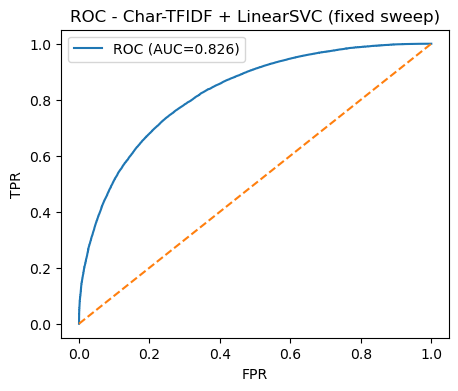

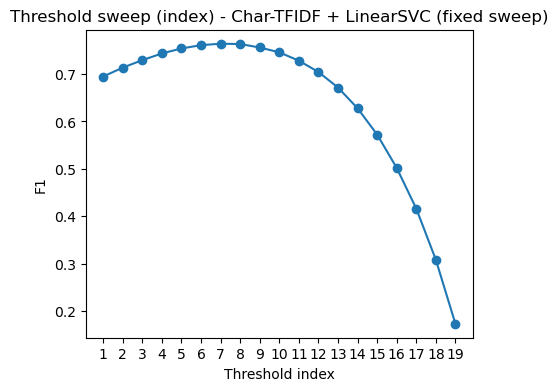

['Char-TFIDF + LinearSVC (best-threshold)'] Precision: 0.6797 | Recall: 0.8712 | F1: 0.7636


(0.6796695110388731, 0.8712108059307615, 0.7636120157044161)

In [ ]:
# default: threshold at 0
y_pred_default = svc_best.predict(X_valid)
evaluate_preds(y_valid, y_pred_default, title="Char-TFIDF + LinearSVC (threshold=0)")

valid_scores_svc = svc_best.decision_function(X_valid)

best_t_svc, best_f1_svc, auc_svc = sweep_threshold_general(
    y_valid, valid_scores_svc, name="Char-TFIDF + LinearSVC (fixed sweep)", is_proba=False
)

y_pred_svc = (valid_scores_svc >= best_t_svc).astype(int)
evaluate_preds(y_valid, y_pred_svc, title="Char-TFIDF + LinearSVC (best-threshold)")

In [ ]:
# fit on all training data and export
best_ngram = gs_svc.best_params_["tfidf__ngram_range"]
best_min_df = gs_svc.best_params_["tfidf__min_df"]
best_subtf = gs_svc.best_params_["tfidf__sublinear_tf"]
best_C = gs_svc.best_params_["clf__C"]

svc_final = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=best_ngram,
        min_df=best_min_df,
        sublinear_tf=best_subtf
    )),
    ("clf", LinearSVC(C=best_C))
])

X_full = train[TEXT_COL].astype(str)
y_full = train[LABEL_COL].astype(int)
svc_final.fit(X_full, y_full)

valid_scores_final = svc_final.decision_function(validation[TEXT_COL].astype(str))

BEST_T_SVC = -0.5435

y_valid_pred_final = (valid_scores_final >= BEST_T_SVC).astype(int)
evaluate_preds(y_valid, y_valid_pred_final, title="FINAL SVC (best-threshold)")

# make_submission(
#     model=svc_final,
#     X_test_text=test[TEXT_COL],
#     save_path="submission_svc_char_ngram.csv",
#     threshold=BEST_T_SVC
# )


['FINAL SVC (best-threshold)'] Precision: 0.6819 | Recall: 0.9520 | F1: 0.7946
[OK] Saved submission to: submission_svc_char_ngram.csv


## Logistic Regression (Tuned)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END clf__C=1.0, clf__class_weight=None, clf__solver=liblinear, tfidf__analyzer=word, tfidf__max_df=0.99, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True;, score=0.553 total time=   4.7s
[CV 2/3] END clf__C=1.0, clf__class_weight=None, clf__solver=liblinear, tfidf__analyzer=word, tfidf__max_df=0.99, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True;, score=0.569 total time=   4.4s
[CV 3/3] END clf__C=1.0, clf__class_weight=None, clf__solver=liblinear, tfidf__analyzer=word, tfidf__max_df=0.99, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True;, score=0.571 total time=   4.5s
[CV 1/3] END clf__C=1.0, clf__class_weight=None, clf__solver=liblinear, tfidf__analyzer=word, tfidf__max_df=0.99, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__sublinear_tf=True;, score=0.528 total time=  16.0s
[CV 2/3] END clf__C=1.0, clf__class_weight=None, clf__solver=liblinear, tf

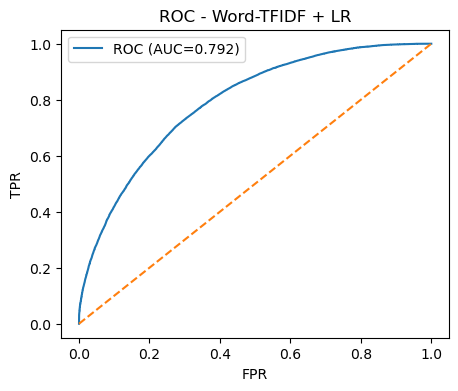

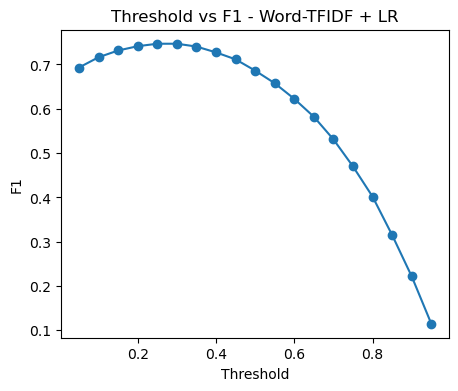

['Word-TFIDF + LR (best-threshold)'] Precision: 0.6644 | Recall: 0.8523 | F1: 0.7467


(0.6644378874421375, 0.8522865377270044, 0.7467295406145421)

In [ ]:
from sklearn.linear_model import LogisticRegression

X_valid = validation[TEXT_COL].astype(str)
y_valid = validation[LABEL_COL].astype(int)

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word"
    )),
    ("clf", LogisticRegression(max_iter=2000, random_state=SEED))
])

param_grid_lr = {
    "tfidf__analyzer": ["word"],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "tfidf__max_df": [0.99],
    "tfidf__sublinear_tf": [True],
    "clf__solver": ["liblinear", "saga"],
    "clf__C": [1.0, 2.0, 4.0],
    "clf__class_weight": [None, "balanced"]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=3,
    n_jobs=1,
    verbose=1
)
gs_lr.fit(X_sub, y_sub)
print("Best params (LR):", gs_lr.best_params_)
print("Best CV F1 (LR):", gs_lr.best_score_)

lr_best = gs_lr.best_estimator_
valid_proba_lr = lr_best.predict_proba(X_valid)[:, 1]
best_t_lr, best_f1_lr, auc_lr = sweep_threshold_and_report(y_valid, valid_proba_lr, name="Word-TFIDF + LR")

y_pred_lr_best = (valid_proba_lr >= best_t_lr).astype(int)
evaluate_preds(y_valid, y_pred_lr_best, title="Word-TFIDF + LR (best-threshold)")


FINAL Word-TFIDF + LR | ROC-AUC: 0.8381
FINAL Word-TFIDF + LR | Best threshold: 0.35 | Best F1: 0.7850


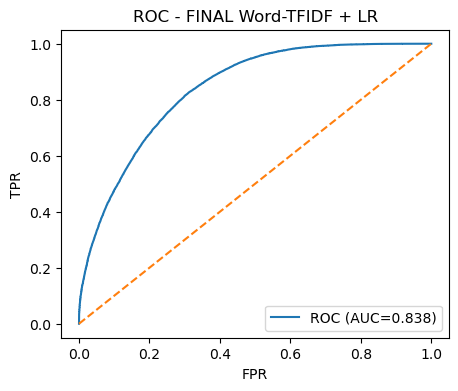

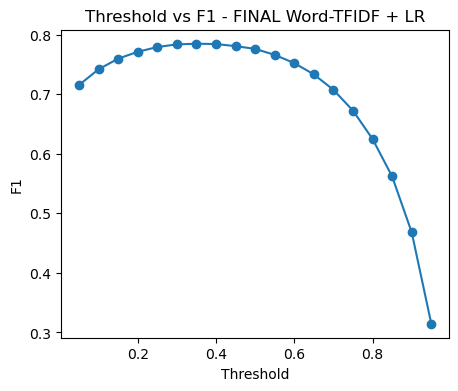

[OK] Saved submission to: submission_lr.csv


In [ ]:
# fit on all training data and export
final_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer=gs_lr.best_params_["tfidf__analyzer"],
        ngram_range=gs_lr.best_params_["tfidf__ngram_range"],
        min_df=gs_lr.best_params_["tfidf__min_df"],
        max_df=gs_lr.best_params_["tfidf__max_df"],
        sublinear_tf=gs_lr.best_params_["tfidf__sublinear_tf"]
    )),
    ("clf", LogisticRegression(
        solver=gs_lr.best_params_["clf__solver"],
        C=gs_lr.best_params_["clf__C"],
        class_weight=gs_lr.best_params_["clf__class_weight"],
        max_iter=2000,
        random_state=SEED
    ))
])

X_full = train[TEXT_COL].astype(str)
y_full = train[LABEL_COL].astype(int)
final_lr.fit(X_full, y_full)

valid_proba_final = final_lr.predict_proba(X_valid)[:, 1]
best_t_final, best_f1_final, auc_final = sweep_threshold_and_report(
    y_valid, valid_proba_final, name="FINAL Word-TFIDF + LR"
)

# make_submission(
#     model=final_lr,
#     X_test_text=test[TEXT_COL],
#     save_path="submission_lr.csv",
#     threshold=best_t_lr
# )


## CNB

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params (CNB): {'clf__alpha': 0.5, 'tfidf__max_df': 0.99, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best CV F1 (CNB): 0.565754032249525
Word-TFIDF + ComplementNB | ROC-AUC: 0.6396
Word-TFIDF + ComplementNB | Best threshold: 0.10 | Best F1: 0.6966


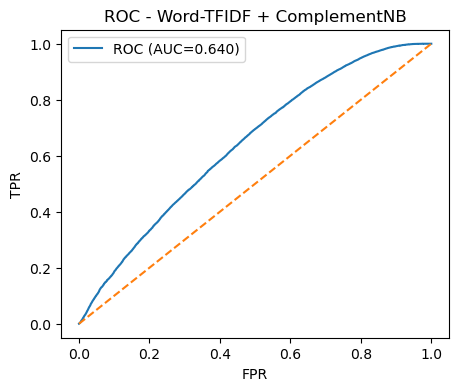

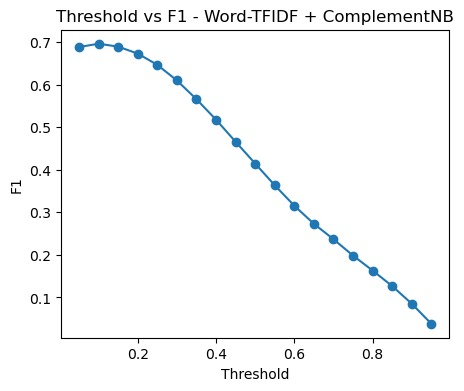

['Word-TFIDF + CNB (best-threshold)'] Precision: 0.5466 | Recall: 0.9599 | F1: 0.6966


(0.5466176267030511, 0.9598597173512969, 0.6965604132543782)

In [70]:
from sklearn.naive_bayes import ComplementNB

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word"
    )),
    ("clf", ComplementNB())
])

param_grid_nb = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "tfidf__max_df": [0.99],
    "tfidf__sublinear_tf": [True],
    "clf__alpha": [0.5, 1.0, 2.0]  # 平滑项
}

gs_nb = GridSearchCV(
    pipe_nb,
    param_grid=param_grid_nb,
    scoring="f1",
    cv=3,
    n_jobs=1,
    verbose=1
)
gs_nb.fit(X_sub, y_sub)
print("Best params (CNB):", gs_nb.best_params_)
print("Best CV F1 (CNB):", gs_nb.best_score_)

# 验证集：概率 + 阈值扫描
nb_best = gs_nb.best_estimator_
valid_proba_nb = nb_best.predict_proba(X_valid)[:, 1]
best_t_nb, best_f1_nb, auc_nb = sweep_threshold_and_report(y_valid, valid_proba_nb, name="Word-TFIDF + ComplementNB")

y_pred_nb_best = (valid_proba_nb >= best_t_nb).astype(int)
evaluate_preds(y_valid, y_pred_nb_best, title="Word-TFIDF + CNB (best-threshold)")


## Ensembled Model (Combine L-SVC, LR-tuned, CNB)

Simple Ensemble (SVC+LR+NB) | ROC-AUC: 0.8415
Simple Ensemble (SVC+LR+NB) | Best threshold: 0.3000 | Best F1: 0.7919


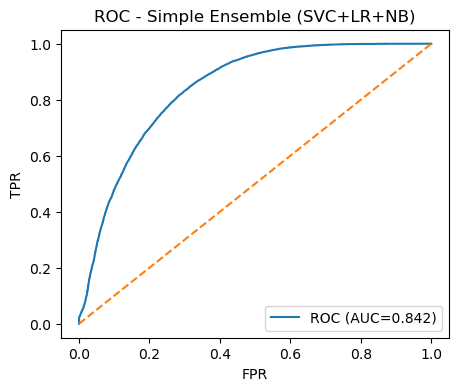

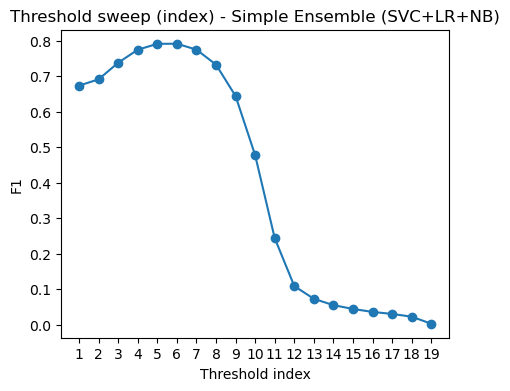

['Ensemble (best-threshold)'] Precision: 0.7170 | Recall: 0.8842 | F1: 0.7919


(0.7170007883770695, 0.8842320913920623, 0.7918836974267278)

In [76]:
final_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1,2),
        min_df=1,
        max_df=0.99,
        sublinear_tf=True
    )),
    ("clf", ComplementNB(alpha=1.0))
])
final_nb.fit(X_full, y_full)

def minmax01(x):
    x = np.asarray(x)
    lo, hi = x.min(), x.max()
    if hi == lo:
        return np.zeros_like(x) + 0.5
    return (x - lo) / (hi - lo)

# SVC: decision_function min-max to [0,1]
svc_val_scores = svc_final.decision_function(validation[TEXT_COL].astype(str))
svc_val_s01 = minmax01(svc_val_scores)

# LR/NB
lr_val_p = final_lr.predict_proba(validation[TEXT_COL].astype(str))[:, 1]
nb_val_p = final_nb.predict_proba(validation[TEXT_COL].astype(str))[:, 1]

# average the probabilities
ens_val = (svc_val_s01 + lr_val_p + nb_val_p) / 3.0

best_t_ens, best_f1_ens, auc_ens = sweep_threshold_general(
    y_valid, ens_val, name="Simple Ensemble (SVC+LR+NB)", is_proba=True
)

y_valid_pred_ens = (ens_val >= best_t_ens).astype(int)
evaluate_preds(y_valid, y_valid_pred_ens, title="Ensemble (best-threshold)")

In [ ]:
# SVC test score (0-1)
svc_test_scores = svc_final.decision_function(test[TEXT_COL].astype(str))
svc_test_s01 = minmax01(svc_test_scores)

# LR/NB
lr_test_p = final_lr.predict_proba(test[TEXT_COL].astype(str))[:, 1]
nb_test_p = final_nb.predict_proba(test[TEXT_COL].astype(str))[:, 1]

ens_test = (svc_test_s01 + lr_test_p + nb_test_p) / 3.0

NameError: name 'make_submission_from_scores' is not defined

In [ ]:
# make_submission_from_scores(
#     test_df=test,
#     id_col=ID_COL,
#     scores=ens_test,
#     threshold=best_t_ens,
#     save_path="submission_ensemble_svc_lr_nb.csv"
# )

[OK] Saved ensemble submission to: submission_ensemble_svc_lr_nb.csv


## Submission

In [ ]:
def make_submission(model, X_test_text, save_path="submission.csv", threshold=None):
    y_test_pred = None
    if threshold is None:
        y_test_pred = model.predict(X_test_text.astype(str))
    else:
        if hasattr(model, "predict_proba"):
            scores = model.predict_proba(X_test_text.astype(str))[:, 1]
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test_text.astype(str))
        else:
            raise ValueError("The current model does not support probability/score threshold-based outputs.")
        y_test_pred = (scores >= threshold).astype(int)

    sub = pd.DataFrame({
        "id": test[ID_COL],
        "label": y_test_pred
    })
    sub.to_csv(save_path, index=False)
    print(f"[OK] Saved submission to: {save_path}")

In [78]:
def make_submission_from_scores(test_df, id_col, scores, threshold, save_path):
    scores = np.asarray(scores)
    y_pred = (scores >= threshold).astype(int)
    out = pd.DataFrame({id_col: test_df[id_col], "label": y_pred})
    out.to_csv(save_path, index=False)
    print("[OK] Saved ensemble submission to:", save_path)


In [ ]:
# make_submission(tfidf_lr, test[TEXT_COL], save_path="submission_baseline.csv")

[OK] Saved submission to: submission_baseline.csv
